In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from pymonad.tools import curry
from math import sqrt,log,inf
from functools import reduce
from statistics import mean,stdev

## Utilities

In [2]:
# importing reduce() from functools
from functools import reduce
def compose(*funcs):
    return reduce(lambda f,g : lambda x : f(g(x)), funcs, lambda x : x)

In [3]:
# patterns : [closure,class,object]
def class_sumstats(size = None) : # sumstats class (a factory)
    wsize = size if size == None else size + 1 
    sumstats = deque([(0.0,0.0,0.0)],wsize)
    def cardinality() :
        nonlocal sumstats
        return len(sumstats) - 1 
    def domain() :
        nonlocal sumstats
        return range(len(sumstats)-1)
    def push(y) :
        nonlocal sumstats,wsize
        last = sumstats[-1]
        sumstats.append((y,last[1] + y,last[2] + y*y))
        if len(sumstats) == sumstats.maxlen :
            y0,sy0,syy0 = sumstats[0]
            sumstats = deque([(y - y0,sy - sy0,syy - syy0) for y,sy,syy in sumstats],
                             wsize)
        return value,domain,cardinality,capacity,push
    def capacity() :
        nonlocal wsize
        return inf if wsize == None else wsize
    def value(i) :
        return sumstats[i]
    return value,domain,cardinality,capacity,push

In [4]:
def class_normal_mean_segment_cost(sumstats) :
    ss_value,ss_domain,ss_cardinality = sumstats
    def cardinality() :
        nonlocal ss_cardinality
        n = ss_cardinality()
        return int(n*(n+1)/2)
    def value(a,b) :
        nonlocal ss_value
        _,sya,syya = ss_value(a)
        _,syb,syyb = ss_value(b+1)
        val = syb - sya
        val *= val
        val /= (b - a + 1)
        val = -val
        val += syyb - syya
        return val
    def domain() :
        nonlocal ss_domain
        outer = ss_domain()
        for a in outer :
            inner = ss_domain()
            for b in inner :
                if b >= a :
                    yield (a,b)
    return value,domain,cardinality
        

In [5]:
def class_right_cost(segment_cost) :
    sc_value,sc_domain,sc_cardinality = segment_cost
    def cardinality() :
        nonlocal sc_cardinality
        return int((sqrt(8*sc_cardinality()+1)-1)/2)
    def domain() :
        return range(cardinality())
    def value(i) :
        nonlocal sc_value
        return sc_value(i,cardinality()-1)
    return value,domain,cardinality

In [6]:
def class_left_cost(segment_cost) :
    sc_value,sc_domain,sc_cardinality = segment_cost
    def cardinality() :
        nonlocal sc_cardinality
        return int((sqrt(8*sc_cardinality()+1)-1)/2)
    def domain() :
        return range(cardinality())
    def value(i) :
        nonlocal sc_value
        return sc_value(0,i)
    return value,domain,cardinality

In [7]:
def class_left_right_cost(left_cost,right_cost) :
    l_value,_,_ = left_cost
    r_value,domain,cardinality = right_cost
    def value(i) :
        nonlocal l_value,r_value
        res = r_value(i)
        if i == 0 :
            return res
        return l_value(i-1) + res
    return value,domain,cardinality

In [8]:
def class_summed_cost(segment_cost) :
    sc_value,sc_domain,sc_cardinality = segment_cost
    def cardinality() :
        nonlocal sc_cardinality
        return int((sqrt(8*sc_cardinality()+1)-1)/2)
    def domain() :
        return range(cardinality())
    def value(i) :
        nonlocal sc_value
        b = cardinality()-1
        res = sc_value(i,b)
        if i == 0 :
            return res
        return sc_value(0,i-1) + res
    return value,domain,cardinality

In [9]:
def split(cost) :
    value,domain,_ = cost
    vmin,loc = min([(value(i),i) for i in domain()])
    return (value(0) - vmin,loc-1)

In [10]:
@curry(3)
def scale(mu,sigma,x) :
    return (x - mu)/sigma

In [11]:
def class_ordered_function(ordered) :
    def cardinality() :
        nonlocal ordered
        return len(ordered)
    def domain() :
        return range(cardinality())
    def value(i) :
        nonlocal ordered
        return ordered[i]
    def push(val) :
        nonlocal ordered
        ordered.append(val)
        return value,domain,cardinality,push,insert
    def insert(i,x) :
        nonlocal ordered
        ordered[i] = x
    return value,domain,cardinality,push,insert

## Cost Functions

In [12]:
def normal_mean(size) :
    value,domain,cardinality,capacity,push = class_sumstats(size)
    value,domain,cardinality = class_normal_mean_segment_cost((value,domain,cardinality))
    return value,domain,cardinality,capacity,push

## At Most One Change (AMOC)

In [13]:
def amoc(cost) :
    value,domain,cardinality,_,push_cost = cost
    left = class_left_cost((value,domain,cardinality))
    right = class_right_cost((value,domain,cardinality))
    value,domain,cardinality = class_left_right_cost(left,right)
    def push(x) :
        nonlocal value,domain,cardinality,push_cost
        push_cost(x)
        return split((value,domain,_))
    return push      

## AMOC example 1

In [14]:
np.random.seed(0)
Z = [float(z) for z in list(np.random.normal(0, 1, 1000)) + 
    list(np.random.normal(1, 1, 1000)) +
    list(np.random.normal(0, 1, 1000))]

scan = compose(amoc(normal_mean(200)),scale(mean(Z),stdev(Z)))
beta = 2*log(len(Z))
history = list()
i = 0
for z in Z : 
    v,p = res = scan(z)
    history.append(res)
    if v > beta :
        pass
        # print("alarm at  " + str(p) + " at time " + str(i))
    i += 1

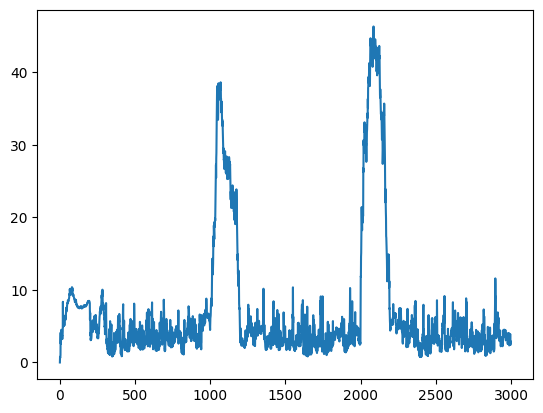

In [15]:
plt.plot([v for v,_ in history])

## Optimal Partitioning (OP)

In [16]:
def op_cpts(cpts) :
    value,_,cardinality,_,_ = cpts
    pos = cardinality() - 1
    locations = []
    while pos > 0 :
        pos = pos - value(pos)
        locations = [pos] + locations
    return locations[1:]

In [17]:
def op(S,x,beta) :
    cost,F,cpts = S
    value,domain,cardinality,capacity,push_cost = cost
    right = class_right_cost((value,domain,cardinality))
    F_value,domain_F,cardinality_F,push_F,_ = F
    cpts_value,domain_cpts,cardinality_cpts,push_cpts,_ = cpts
    push_cost(x)
    value,domain,cardinality = class_left_right_cost((F_value,domain_F,cardinality_F),right)
    severity,location = split((value,domain,cardinality))
    if severity > beta :
        push_F(value(location) + beta)
        push_cpts(cardinality_cpts() - location)
    else :
        push_F(value(0))
        push_cpts(cardinality_cpts())
    return cost,F,cpts

                           

## Changepoint

In [18]:
def scale_F(S) :
    cost,F,cpts = S
    value,domain,_,_,_ = F
    _,_,_,capacity,_ = cost
    f0 = value(0)
    F = class_ordered_function(deque([value(i) - f0 for i in domain()],maxlen=capacity()))
    return cost,F,cpts

In [19]:
def changepoint(cost,beta) :
    _,_,_,capacity,_ = cost
    F = class_ordered_function(deque([],maxlen=capacity()))
    cpts = class_ordered_function(deque([],maxlen=capacity()))
    S = (cost,F,cpts)
    def push(x) :
        nonlocal S,beta
        _,_,cpts = S = op(S,x,beta)
        S = scale_F(S)
        return op_cpts(cpts)
    return push


## Changepoints Example 1

In [20]:
np.random.seed(1)
Z = [float(z) for z in list(np.random.normal(0, 1, 900)) + 
    list(np.random.normal(1, 1, 200)) +
    list(np.random.normal(0, 1, 900))]

beta = 3*log(len(Z))
cost = normal_mean(2000)
scan = compose(changepoint(cost,beta),scale(mean(Z),stdev(Z)))
history = list()
for z in Z :
    history.append(scan(z))


In [21]:
history[-1]

[899, 1101]

## CAPA

In [83]:
def capa_normal_mean(size) :
    return (normal_mean(size),
            lambda x,beta,beta_dash : x*x,
            lambda x,beta,beta_dash : 1 + beta_dash)

In [67]:
def capa_cpts(cpts) :
    value,_,cardinality,_,_ = cpts
    pos = cardinality() - 1
    locations = []
    while pos > 0 :
        location,category = value(pos) # no anomaly
        if category == 0 : # collective anomaly
            locations.insert(0,(pos-location,pos))
        pos = pos - location
        if category == 2 : # point anomaly
            locations.insert(0,pos)
    return locations

In [89]:
def capa(cost,beta,beta_dash) :
    C1,C2,C3 = cost
    cost = C1
    _,_,_,capacity,_ = cost
    F = class_ordered_function(deque([],maxlen=capacity()))
    cpts = class_ordered_function(deque([],maxlen=capacity()))
    S = (cost,F,cpts)
    def push(x) :
        nonlocal S,beta,beta_dash
        (_,_,_,capacity,_),(value,_,cardinality,_,_),_ = S
        fprev = inf
        if cardinality() > 1 :
            fprev = value(cardinality()-1)
        _,F,cpts = S = op(S,x,beta)
        value,_,cardinality,push,insert = F
        f = value(cardinality()-1)
        value,_,cardinality,_,_ = cpts
        pos = value(cardinality()-1)
        value,category = min((f,0),(fprev+C2(x,beta,beta_dash),1),(fprev+C3(x,beta,beta_dash),2))
        insert(cardinality()-1,value)
        _,_,cardinality,_,insert = cpts
        insert(cardinality()-1,(pos,category))
        S = scale_F(S)
        return capa_cpts(cpts)
    return push
    
    

In [92]:
np.random.seed(1)
Z = [float(z) for z in list(np.random.normal(0, 1, 900)) + 
    list(np.random.normal(1, 1, 200)) +
    list(np.random.normal(0, 1, 900))]
Z[200] = 10

trans = scale(mean(Z),stdev(Z))
beta = 4*log(len(Z))
beta_dash = 3*log(len(Z))
cost = capa_normal_mean(2000)

scan = compose(capa(cost,beta,beta_dash),scale(mean(Z),stdev(Z)))
history = list()
for z in Z :
    history.append(scan(z))

history[1999]

[199, (900, 1101)]